# QAOA Implementation Demo
**Author: Cooper Midroni**
<br>
cooper@entropicalabs.com

In this notebook we demonstrate a start-to-finish project workflow for using Quantum Approximate Optimization Algorithm to cluster a simple dataset. Along the way, we will explain the major concepts of QAOA and build intuition as to how QAOA can be used to solve clustering problems. This notebook will steer away from heavy mathematical explanations in favor of a higher level view of the algorithm's core components. We recognize that understanding QAOA's mathematics is a valuable lens for using this tool, and have created a second notebook for the courageous few who wish to build this deeper understanding.

We recommend to all that they first use this notebook, as the two are made to provide one cohesive narrative and contain mostly mutually exclusive information. 

## Index
1. [Variational Hybrid Algorithms](#variational_hybrid_algorithms)
2. [Understanding MAXCUT](#understanding_maxut)
3. [Cost Function](#cost_function)
4. [Adiabatic Computing](#adiabatic_computing)
5. [Understanding QAOA Parameter Schemes](#understanding_qaoa_parameter_schemes)
6. [Additional Workflow Tools](#additional_workflow_tools)
7. [Conclusions](#conclusions)

***
## Variational Hybrid Algorithms

We often take for granted the many decades of progress that lead to today's widespread use of classical computers. As memory and compute power become ever cheapened by Moore's Law, the pressure to find optimal resource allocations for algorithms shrinks away. However, with quantum computers in their early stages, they still feel this daunting requirement. In response to this, a family of algorithms known as *variational hybrid quantum-classical algorithms* was created, with the notion that quantum resources can be made more useful when partnered with classical routines. The Quantum Approximate Optimization Algorithm (QAOA), belongs to the family of variatonal hybrid algorithms. 

We can infer a lot from merely unpacking this name. The presence of '*variational*' tells us these algorithms will follow an iterative approach, while '*hybrid*' tells us they will leverage the use of both quantum and classical computers. In fact, this describes the main flow of the algorithm, with all that needs be answered is *when* does this iteration stop and *what* information is passed between devices.

<center><img src="imgs/general_variational.png" style="width:600px";></center>
<center><i> A visual representation of a generic variational hybrid quantum-classical algorithm.</i></center>

To answer the question of *what*, we note that the main goal of QAOA is optimize a set of **parameters**, which we denote as $\vec{\gamma}$ and $\vec{\beta}$. You'll notice that these symbols are vectors, as such they are $n-$length. We discuss later what aspects of our problem decide the value of $n$ in the second notebook. 

$\vec{\gamma}$ and $\vec{\beta}$ parameterize a **cost function** which is evaluated with our **Quantum Circuit** to produce a cost value. This output value is input to the optimizer, and is used to determine whether the nudging of our parameters is in a direction of lower cost. We will sometimes call the cost value an **expectation value**, represented by $\langle\psi|Cost|\psi\rangle$, which is the expected value of the cost function $Cost$ over the **wave function** $\psi$. If you were caught off guard by the term 'wave function', then it is equally as effective to think of $\langle\psi|Cost|\psi\rangle$ as the notion of cost as in the more traditional machine learning sense. The **Classical Optimizer** will return updated parameters to the quantum circuit for re-evaluation, and the cycle repeats. 

*When* does this algorithm stop? Well, once a stopping criterion is met of course. This criterion is often a pre-defined maximum number of iterations, or occurs after a repeat number of evaluations land within the same threshold of convergence (a tolerance for the cost value in which we consider numbers within an $\epsilon-$window the same). Once this criterion is met, the **optimized parameters** are returned and used to define the solution. 

<br>
<center><img src="imgs/variational.png" style="width:600px";></center>
<center><i> A visual representation of QAOA in the format of a variational hybrid algorithm.</i></center>
<br>

The above description should leave you with many questions.
- How does the above process solve a clustering problem?
- How exactly do $\vec{\gamma}$ and $\vec{\beta}$ define the solution?
- How do we define a meaningful cost function for our problem?
- What in the world is a wave function?

We hope to answer these and more. For now, if you feel comfortable with the critical vocabulary of QAOA (the bolded words), then you'll be well prepared for the explanations below.
***
## Data Preparation
Now let's get to the fun part! We will import our data and define the problem setting as a highly manicured example for this clustering demo. 

The dataset we will be using is the **Pokemon dataset**, which can be found on [Github](https://gist.github.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6). In our journey to Catch 'Em All, we will attempt to cluster Pokemon into Legendary and non-Legendary classes. 

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Data


In [2]:
df = pd.read_csv('./data/pokemon.csv')
df = df.set_index('#') #index pokemon by their ID number
df = df.rename_axis('ID') #rename axis to 'ID' instead of '#'
df = df.loc[~df.index.duplicated(keep='first')] #drop duplicates
df.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
ID,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False


To avoid the many bells and whistles of later iterations of Pokemon games, we'll stick to our roots and only consider Pokemon from the first three generations.

In [3]:
df = df.loc[df['Generation']<=3]
df.sample(frac=1).head() #sample the whole dataset (frac=1) to shuffle the arrangement

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
ID,,,,,,,,,,,,
67,Machoke,Fighting,NaN,405,80,100,70,50,60,45,1,False
361,Snorunt,Ice,NaN,300,50,50,50,50,50,50,3,False
178,Xatu,Psychic,Flying,470,65,75,70,95,70,95,2,False
170,Chinchou,Water,Electric,330,75,38,38,56,56,67,2,False
210,Granbull,Fairy,NaN,450,90,120,75,60,60,45,2,False


In [4]:
print('Percent of Non-Legendary Pokemon: %.2f' %((df.Legendary.count()-df.Legendary.sum())/df.Legendary.count()))
print('Percent of Legendary Pokemon: %.2f' %((df.Legendary.sum())/df.Legendary.count()))

Percent of Non-Legendary Pokemon: 0.95
Percent of Legendary Pokemon: 0.05


We can see that the classes are quite unevenly distributed. To remedy this, we will randomly select 5 Legendary and 5 Non-Legendary Pokemon to act as our samples to be clustered.

In [5]:
legendary = df.loc[df['Legendary'] == True].sample(5)
non_legendary = df.loc[df['Legendary'] == False].sample(5)
pokemon = pd.concat([legendary,non_legendary])

To further simplify the problem, and not worry about the encoding of categorical data, we will only consider numerical values in our clustering of the data.

In [6]:
numerical_columns = ['Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']

In [7]:
labels = pokemon['Legendary']
data = pokemon[numerical_columns].copy()
data.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
ID,,,,,,,
380,600,80,80,90,110,130,110
384,680,105,150,90,150,90,95
385,600,100,100,100,100,100,100
377,580,80,100,200,50,100,50
250,680,106,130,90,110,154,90


We now have a dataset which is ready to be processed, but we may not be exactly clear on what to do with it. For that we must further understand how the QAOA process detailed above is actually used to solve a clustering problem.
***
## Understanding Maxcut

As laid out by [Rigetti's paper on QAOA](https://arxiv.org/pdf/1712.05771.pdf), there are a number of important steps that we must follow to map the problem of clustering into a format which QAOA can process. Broadly speaking, QAOA solves the **MAXCUT** problem, in which a graph of $n$ vertices is separated into two complementary subsets, $S$ and $S^{c}$, such that the number of edges between $S$ and $S^{c}$ is as large as possible.
<br>
<br>
<center><img src="imgs/maxcut.png"></center>
<center><i> A depiction of the maxcut problem, displaying a cut which separates white and black vertices.</i></center>
<br>
<br>    
This problem can be made more sophisticated by adding numerical values as <i>weights</i> to the edges, such that the best solution maximizes the sum of weights which separate $S$ and $S^{c}$. This is precisely the approach we take in using MAXCUT to cluster our data. 

We allow the weights associated to each edge to be some notion of distance between points. In this way, the sets dictated by our optimal cut, $S$ and $S^{c}$, separate the data into binary clusters which are maximally distant (and hence, maximally dissimilar) from one another.

From our current understanding, we can already begin to formulate some first steps in preparing our data to fit this frameowrk.

We can use SciPy's built in `distance_matrix` function to easily turn this set of points into the desired matrix of pairwise distances. Recall, that a distance matrix can be interpretted as the adjacency matrix of a graph.

In [8]:
from scipy.spatial import distance_matrix
dist = pd.DataFrame(distance_matrix(data.values,data.values,p=2),
                       index=data.index,columns=data.index)
dist

ID,380,384,385,377,250,275,246,88,267,142
ID,,,,,,,,,,
380,0.000000,123.895117,44.721360,144.913767,102.722928,148.323970,328.849510,309.434969,229.455878,120.000000
384,123.895117,0.000000,107.935166,193.261481,78.243211,219.886334,414.683011,389.551024,310.241841,200.124961
385,44.721360,107.935166,0.000000,125.698051,102.722928,134.907376,324.502696,301.081384,225.277607,109.544512
377,144.913767,193.261481,125.698051,0.000000,178.303113,183.847763,325.118440,301.910583,251.495527,172.046505
250,102.722928,78.243211,102.722928,178.303113,0.000000,226.698037,413.441652,388.255071,316.357393,198.725942
275,148.323970,219.886334,134.907376,183.847763,226.698037,0.000000,197.590486,173.925271,97.724101,70.710678
246,328.849510,414.683011,324.502696,325.118440,413.441652,197.590486,0.000000,45.409250,112.969022,240.420465
88,309.434969,389.551024,301.081384,301.910583,388.255071,173.925271,45.409250,0.000000,102.956301,221.359436
267,229.455878,310.241841,225.277607,251.495527,316.357393,97.724101,112.969022,102.956301,0.000000,150.665192


In [9]:
dist.index

Int64Index([380, 384, 385, 377, 250, 275, 246, 88, 267, 142], dtype='int64', name='ID')

In [10]:
df.loc[dist.index]

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
ID,,,,,,,,,,,,
380,Latias,Dragon,Psychic,600,80,80,90,110,130,110,3,True
384,Rayquaza,Dragon,Flying,680,105,150,90,150,90,95,3,True
385,Jirachi,Steel,Psychic,600,100,100,100,100,100,100,3,True
377,Regirock,Rock,NaN,580,80,100,200,50,100,50,3,True
250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,True
275,Shiftry,Grass,Dark,480,90,100,60,90,60,80,3,False
246,Larvitar,Rock,Ground,300,50,64,50,45,50,41,2,False
88,Grimer,Poison,NaN,325,80,80,50,40,50,25,1,False
267,Beautifly,Bug,Flying,395,60,70,50,100,50,65,3,False


## From MAXCUT to QUBO
With an understanding of the MAXCUT structure which produces our clustered output, we ask ourselves how we can turn what is effectively a graph problem into the setting of an optimization problem. The answer is to map our MAXCUT interpretation into a **Quadratic Unconstrainted Binary Optimization** ([QUBO](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization)) problem. QUBO problems attempt to minimize a quadratic polynomial with binary variables. Luckily, MAXCUT already has a well-known QUBO cost function. This cost function is sophisticated enough to allow for our pairwise distanes to be meaningfully included, as well as to allow for the inclusion of bias terms on individual samples. A more detailed explanation about the construction of this cost function is in the second notebook. <br><br>
<center> $Cost=-\sum_{\langle i j\rangle} J_{i j} \sigma_{i} \sigma_{j}-\mu \sum_{j} h_{j} \sigma_{j}$ </center>

To explain the notation:
- $\sigma_{i}$ is the cluster class (-1 or 1) of sample $i$
- $J_{i j}$ is the distance between sample $i$ and sample $j$
- $h_{j}$ is a bias term on sample $j$ 
- $\mu$ is a universal weight applied to all bias terms

By convention, a negative sign is applied to the cost function, as above. In quantum mechanics we would denote thie function as $H(\sigma)$. The symbol $H$ stands for *Hamiltonian*, which is an operator which acts as a sum of the energies of the system. For the scope of this notebook, thinking of $Cost$ as any traditional cost function which we want to minimize will serve us equally as valuable.

***
## Create the Hamiltonian
Now we must use our data to create the cost function defined above. To make a Hamiltonian that is recognizable by pyQuil, we must use the pyQuil `PauliTerm` object.

In [11]:
from pyquil.api import WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm

A `PauliTerm` object can be quadratic or of order one. In the case of it being quadratic, it  represents the relationship between any two samples of data. An order one `PauliTerm` would be an implementation of a bias term - a cost constraint which only affects one variable. Below we show some basic functionality of the `PauliTerm` object.

In [12]:
#Constructing a quadratic PauliTerm
i = 3
j = 6
print('Distance between samples %d and %d: %.3f' %(i,j,dist.values[i][j]))

Distance between samples 3 and 6: 325.118


To create the quadratic term we multiply two Paulis together. Each `PauliTerm` has an accompanying coefficient which is also multiplied. For simplicity's sake, we include the pairwise distance as a coefficient of one term, and make the other '1.0'.

In [13]:
term1 = PauliTerm("Z",i,dist.values[i][j])
term2 = PauliTerm("Z",j,1.0) 
term = term1*term2
print(term)

(325.1184399568871+0j)*Z3*Z6


Feel free to play with the coefficient number of `term2` to see how it affects the output of the cell.

For those new to quantum, you're likely wondering what the purpose of the letter 'Z' is. It indicates that this `PauliTerm` is a Z operator.

You may also note that our sample numbers, $i=3$ and $j=6$, have found their way into the printed output. Including $i$ and $j$ in each `PauliTerm` tells pyQuil which samples or **qubits** the operation is applied to. That's right, in the QAOA setup, we consider each datapoint to be mapped to a qubit. Thus, the above printed statement actually means:
```
Apply a penalty of 186.548 should sample 3 and sample 6 be in the same class. 
```
Or in a more quantum-intuitive sense:
```
Apply a penalty of 186.548 should qubit 3 and qubit 6 both be found to be in the same spin state (spin up or spin down). 
```

Thus, as QAOA tries to minimize the cost function, sample 3 and 6 will only appear in the same class if this configuration is optimal.

In [14]:
term1 = PauliTerm("Z",0,) 

We can see now that to make the Hamiltonian for our system we must iterate over each distance in our distance matrix, and assign it within a `PauliTerm` as the interaction strength between the appropriate qubits.

In [15]:
pauli_list = list()
m,n = dist.shape

#pairwise interactions
for i in range(m):
    for j in range(n):
        if i < j:
            term = PauliTerm("Z",i,dist.values[i][j])*PauliTerm("Z",j, 1.0) #we set the second term to 1, so we don't scale the distances
            pauli_list.append(term)

In [16]:
hamiltonian = PauliSum(pauli_list)
print(hamiltonian)

(123.89511693363868+0j)*Z0*Z1 + (44.721359549995796+0j)*Z0*Z2 + (144.9137674618944+0j)*Z0*Z3 + (102.72292830717006+0j)*Z0*Z4 + (148.32396974191326+0j)*Z0*Z5 + (328.84950965449224+0j)*Z0*Z6 + (309.434968935316+0j)*Z0*Z7 + (229.4558781116753+0j)*Z0*Z8 + (120+0j)*Z0*Z9 + (107.93516572461452+0j)*Z1*Z2 + (193.26148090087688+0j)*Z1*Z3 + (78.24321056807422+0j)*Z1*Z4 + (219.88633427296023+0j)*Z1*Z5 + (414.6830114677957+0j)*Z1*Z6 + (389.5510236156491+0j)*Z1*Z7 + (310.2418411497714+0j)*Z1*Z8 + (200.124960961895+0j)*Z1*Z9 + (125.69805089976535+0j)*Z2*Z3 + (102.72292830717006+0j)*Z2*Z4 + (134.90737563232042+0j)*Z2*Z5 + (324.50269644488316+0j)*Z2*Z6 + (301.0813843464919+0j)*Z2*Z7 + (225.27760652137619+0j)*Z2*Z8 + (109.54451150103323+0j)*Z2*Z9 + (178.30311270418136+0j)*Z3*Z4 + (183.84776310850236+0j)*Z3*Z5 + (325.1184399568871+0j)*Z3*Z6 + (301.91058278901056+0j)*Z3*Z7 + (251.49552679918582+0j)*Z3*Z8 + (172.04650534085255+0j)*Z3*Z9 + (226.69803704487606+0j)*Z4*Z5 + (413.4416524734778+0j)*Z4*Z6 + (388

The above exercise brings up an important limitation to our present QAOA approach. The number of datapoints we are able to use is limited by the number of qubits we have available.

## From Hamiltonian To Clusters
<br>
<br>
<center><img src="imgs/spins.png"style="width:200px"></center>
<center><i> A depiction of the maxcut problem, displaying a cut which separates white and black vertices.</i></center>
<br>
<br>  



It is possible to take inspiration from stati

'optimize' such a problem to result in the best possible cut. 

## Apply QAOA

In [17]:
# import the neccesary pyquil modules
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnQVM, QAOACostFunctionOnWFSim

# import the QAOAParameters that we want to demo
from entropica_qaoa.qaoa.parameters import ExtendedParams
from entropica_qaoa.utilities import return_lowest_state

# import an optimizer
from scipy.optimize import minimize

#Some utilities for time tracking and measuring our outcomes.
import time
from math import log
from sklearn.metrics import accuracy_score

### Choose the Problem Hyperparameters

In [18]:
timesteps = 3
end_time = 1
iters = 500
num_q = 10 #this number might be defined before your dataset
#The hamiltonian is also a hyperparameter

### Generate Parameters
In this QAOA run, we will use `ExtendedParameters`. This parameter class provides the most degrees of freedom for our optimizer to explore the energy landscape. Conversely, it also has the most parameters to optimize and thus will take longer to converge. 

To insantiate this parameter class, we need to pass in three separate lists of angles.
- $\vec{\beta}$: every timestep requires 'nqubit' beta rotations. Thus there are $nqubit\cdot timestep$ beta values.
- $\vec{\gamma}_{pairs}$: there is a gamma rotation for every two-qubit interaction. A simple way to come up with this number is to measure the length of your hamiltonian subtracted by the number of single qubit bias terms in place.
- $\vec{\gamma}_{singles}$: there is a gamma single rotation for each bias term included in the hamiltonian.

We randomly generate these lists as their initial starting states are somewhat redunant. They will be optimized over 100s of iterations!

In [19]:
betas = [round(val,1) for val in np.random.rand(timesteps*num_q)]
gammas_singles = [round(val,1) for val in np.random.rand(0)] #we don't want any bias terms
gammas_pairs = [round(val,1) for val in np.random.rand(timesteps*len(hamiltonian))]

hyperparameters = (hamiltonian, timesteps)
parameters = (betas, gammas_singles, gammas_pairs)

params = ExtendedParams(hyperparameters, parameters)

Before starting the simulator, make sure you are running rigetti's QVM and Quil Compiler
### First QAOA Run: 3 Timesteps, 500 Iterations

In [20]:
# Set up the WavefunctionSimulator from pyQuil
sim = WavefunctionSimulator()
cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                            params=params,
                                            sim=sim,
                                            enable_logging=True)

In [21]:
t0 = time.time()
res = minimize(cost_function, params.raw(), tol=1e-3, method="Cobyla",
               options={"maxiter": iters})
print('Run complete!\n','Runtime:','{:.3f}'.format(time.time()-t0))

Run complete!
 Runtime: 97.733


In [22]:
def return_lowest_state(probs):
    index_max = max(range(len(probs)), key=probs.__getitem__)
    string = '{0:0'+str(int(log(len(probs),2)))+'b}'
    string = string.format(index_max)
    return [int(item) for item in string]

In [24]:
wave_func = cost_function.get_wavefunction(params.raw())
lowest = return_lowest_state(wave_func.probabilities())

In [25]:
true_clusters = [1 if val else 0 for val in labels] 
print('True Labels of samples:',true_clusters)
print('Lowest QAOA State:',lowest)

from sklearn.metrics import accuracy_score
acc = accuracy_score(lowest,true_clusters)
print('Accuracy of Original State:',acc*100,'%')

#Account for the complement bit string in case a class-swap
final_c = [0 if item == 1 else 1 for item in lowest]

acc_c = accuracy_score(final_c,true_clusters)
print('Accuracy of Complement State:',acc_c*100,'%')

True Labels of samples: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Lowest QAOA State: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Accuracy of Original State: 20.0 %
Accuracy of Complement State: 80.0 %


We can analyze the optimizer to see whether or not our QAOA run converged. For the full message, run:
```python
print(res)
```

In [26]:
print('Cost Function Value:', res.fun)
print('Converged?:',res.message)

Cost Function Value: -331.1296757887287
Converged?: Maximum number of function evaluations has been exceeded.


We can see we did not converge. Let's tighten up our operations by wrapping our QAOA runs in a function and increase the number of iterations.

In [31]:
def run_qaoa(hamiltonian, params, timesteps=2, end_time=1,
             max_iters=150, init_state=None): 
    cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                            params=params,
                                            initial_state=init_state)
    res = minimize(cost_function, params.raw(), tol=1e-3, method="Cobyla",
                          options={"maxiter" : max_iters})
    
    return cost_function.get_wavefunction(params.raw()), res


In [32]:
t0 = time.time()
wave_func, res = run_qaoa(hamiltonian, params, timesteps=2, max_iters=1000)
print('Run complete\n','Runtime:','{:.3f}'.format(time.time()-t0))

Run complete
 Runtime: 185.292


In [33]:
lowest = return_lowest_state(wave_func.probabilities())

In [34]:
true_clusters = [1 if val else 0 for val in labels] 
print('True Labels of samples:',true_clusters)
print('Lowest QAOA State:',lowest)

from sklearn.metrics import accuracy_score
acc = accuracy_score(lowest,true_clusters)
print('Accuracy of Original State:',acc*100,'%')

#Account for the complement bit string in case a class-swap
final_c = [0 if item == 1 else 1 for item in lowest]

acc_c = accuracy_score(final_c,true_clusters)
print('Accuracy of Complement State:',acc_c*100,'%')

True Labels of samples: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Lowest QAOA State: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Accuracy of Original State: 0.0 %
Accuracy of Complement State: 100.0 %


In [35]:
df.loc[data.index]

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
ID,,,,,,,,,,,,
380,Latias,Dragon,Psychic,600,80,80,90,110,130,110,3,True
384,Rayquaza,Dragon,Flying,680,105,150,90,150,90,95,3,True
385,Jirachi,Steel,Psychic,600,100,100,100,100,100,100,3,True
377,Regirock,Rock,NaN,580,80,100,200,50,100,50,3,True
250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,True
275,Shiftry,Grass,Dark,480,90,100,60,90,60,80,3,False
246,Larvitar,Rock,Ground,300,50,64,50,45,50,41,2,False
88,Grimer,Poison,NaN,325,80,80,50,40,50,25,1,False
267,Beautifly,Bug,Flying,395,60,70,50,100,50,65,3,False


Your own performance will vary based on which Pokemon were randomly selected from each class. Results can be improved. 

In [36]:
from sklearn.decomposition import PCA

In [37]:
pca = PCA(n_components=5).fit(data)

In [38]:
PCA(n_components=5).fit(data).explained_variance_

array([22304.30979744,  2029.52236747,   591.8662462 ,   421.48858433,
         325.75745541])

In [39]:
def pca_results(data, pca):    
    # Dimension indexing
    dimensions = ['PC-{}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))
    
    plt.subplots_adjust(top=0.9)
    
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

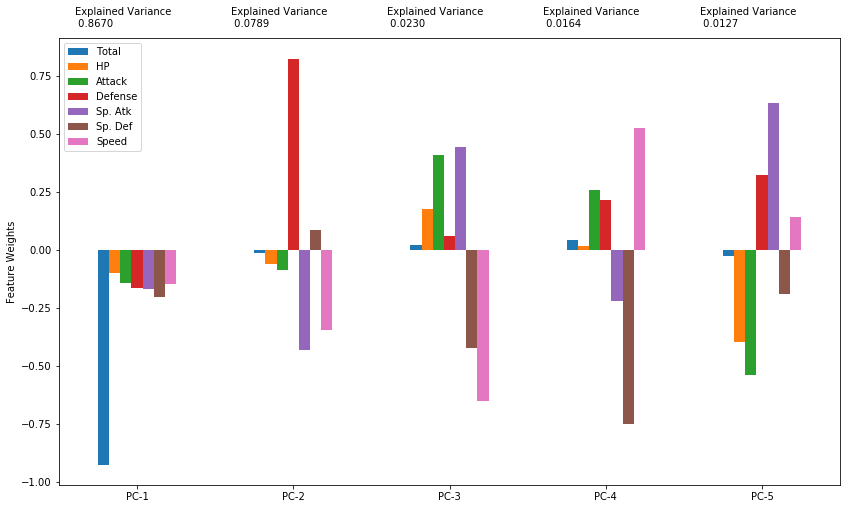

In [40]:
pca_results = pca_results(data, pca)

In [41]:
pca_results.cumsum()

,Explained Variance,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
PC-1,0.8670,-0.9231,-0.0999,-0.1431,-0.1632,-0.1678,-0.2035,-0.1457
PC-2,0.9459,-0.9352,-0.1601,-0.2313,0.6600,-0.5972,-0.1165,-0.4904
PC-3,0.9689,-0.9140,0.0174,0.1766,0.7221,-0.1521,-0.5389,-1.1394
PC-4,0.9853,-0.8711,0.0330,0.4333,0.9363,-0.3712,-1.2887,-0.6141
PC-5,0.9980,-0.8974,-0.3613,-0.1030,1.2573,0.2599,-1.4766,-0.4740


# Experimental

In [42]:
#This function can create the loading plot from PCA along any PCs indicated in components = list()
def loading_plot_color(reduced_data, pca, components=[1,2]):
    fig, ax = plt.subplots(figsize = (10,8))
    # scatterplot of the reduced data 
    pc1 = 'PC-'+str(components[0])
    pc2 = 'PC-'+str(components[1])
    
    coords_x0, coords_x1, coords_y0, coords_y1 = list(), list(), list(), list()
    
    for i, target in enumerate(reduced_data['label']):
        if target == 0:
            print('yes')
            coords_x0.append(reduced_data.loc[:,pc1][i])
            coords_y0.append(reduced_data.loc[:,pc2][i])
        else:
            coords_x1.append(reduced_data.loc[:,pc1][i])
            coords_y1.append(reduced_data.loc[:,pc2][i])
    
    #Plot class 0
    ax.scatter(x=coords_x0, y=coords_y0, 
               edgecolors='b',color='blue', s=70, alpha=0.75)
    
    #Plot class 1
    ax.scatter(x=coords_x1, y=coords_y1, 
               edgecolors='g',color='green', s=70, alpha=0.75)

    feature_vectors = pca.components_.T
    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[components[0]-1], arrow_size*v[components[1]-1], head_width=0.2, head_length=0.15, linewidth=1, color='red',alpha=0.5)
        ax.text(v[components[0]-1]*text_pos, v[components[1]-1]*text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=18)
        
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_xlabel(pc1, fontsize=14)
    ax.set_ylabel(pc2, fontsize=14)
    ax.set_title("Feature projection along the " + pc1 + ' by ' +pc2 + ' plane.', fontsize=16);
    plt.subplots_adjust(top=0.9)
    plt.show()
    return ax

In [43]:
pca = PCA(n_components = 6)
reduced_data = pd.DataFrame(pca.fit_transform(data), 
                            columns = ['PC-{}'.format(i) for i in range(1,len(pca.components_)+1)])
reduced_data['label'] = [1 if val else 0 for val in labels.values]

yes
yes
yes
yes
yes


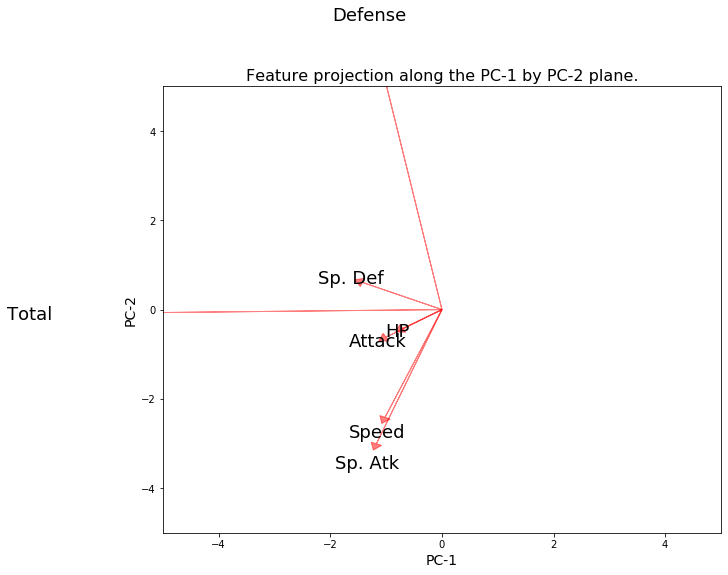

In [44]:
loading_plot_color(reduced_data, pca);